# DDPG : Deep Deterministic Policy Gradient

---

In this notebook, we will train OpenAI Gym's Pendulum environment with DDPG algorithm. 

### 1. Import the Necessary Packages

In [18]:
import gym
from gym import wrappers
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import copy
import random

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

  Using cached https://files.pythonhosted.org/packages/69/ec/8221a07850d69fa3c57c02e526edd23d18c7c05d58ed103e3b19172757c1/PyVirtualDisplay-0.2.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/8f/88d636f1da22a3c573259e44cfefb46a117d3f9432e2c98b1ab4a21372ad/EasyProcess-0.2.10-py2.py3-none-any.whl


device(type='cuda', index=0)

### 2. Define Noise policy
This noise is added to the actions and not on the weights. It aims to improve the exploration factor of the agents.

In [14]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(2)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### 3. Define a ReplayBuffer:
This buffer memory is used to store the experiences by the agents and then taken at random to learn from those 
experiences. 

In [6]:
class ReplayBuffer:
    def __init__(self,buffer_size, action_size):
        self.seed = 2
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experiences", field_names=["state","action","reward","new_state","done"])
        
    def add(self, state, action, reward, new_state, done):
        e = self.experiences(state,action,reward,new_state,done)
        self.memory.append(e)
        
    def sample(self, batch_size):
        experiences = random.sample(self.memory,batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, new_states, dones
    
    def __len__(self):
        return len(self.memory)
    

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### 4. Define the Critic :
The critic part is used to evaluate the actions taken by the agents and produce Q values corresponding to those 
actions.

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(2)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 5. Define the Actor
The actor taken in the current state of the environment and takes policy based actions. Those actions are then
fed to critic network with the current state values to evaluate the actions takens.

In [9]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(2)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


### 6. Define the hyper parameters

In [15]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 10

### 7. Define the Architecture of the Policy
As you will notice, we have two critic and two actor neural networks. Since both the critic and actor network 
is fed with data at "every" single timestep, we cannot use that same neural network to perform training as well.
If so, the network will be all over of the place - training and learning at the same time. 

Therefore, we need separate networks for learning and training purposes. 

Also, unlike REINFORCE algorithm where we only used to train the network after a fixed number of timestep, 
we are training at "every" single timestep.

And after learning and training step is done, we do a soft update where we set the learning network parameter to
be equal to training network parameters, so as to maintain consistency in the actions taken.

In [11]:
class DDPGAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(2)
        
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)
        
        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size)
        
        self.memory = ReplayBuffer(BUFFER_SIZE, action_size)
        
        self.t_step = 0
        
    def step(self, state, action, reward, new_state, done):
        self.memory.add(state, action, reward, new_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
#         if self.t_step == 0:
        if(len(self.memory) > BATCH_SIZE):
            experiences = self.memory.sample(BATCH_SIZE)
            self.learn(experiences, GAMMA)
                
    def reset(self):
        self.noise.reset()
                
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
#         print(action)
        
        if add_noise:
            action += self.noise.sample()
            
        return np.clip(action, -1, 1)
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
            
        

In [16]:
env = gym.make('Pendulum-v0')
env.seed(2)
agent = DDPGAgent(state_size=3, action_size=1)

### 8. Train the Agent with DDPG 
I have here trained the agent for 100 episodes and it seemed to do the task pretty well. 

Episode 100	Average Score: -718.51
Episode 200	Average Score: -660.09
Episode 300	Average Score: -628.28
Episode 400	Average Score: -562.38
Episode 500	Average Score: -402.13
Episode 600	Average Score: -535.46
Episode 700	Average Score: -691.52
Episode 800	Average Score: -719.08
Episode 900	Average Score: -790.98
Episode 1000	Average Score: -851.61


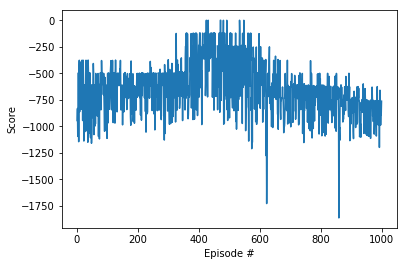

In [13]:
def ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_scores = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
#         if(np.mean(scores_deque) > best_scores):
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
#         torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#         torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. Watch a Smart Agent!

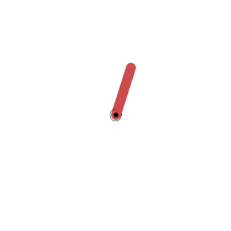

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_ddpg_pendulum.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_ddpg_pendulum.pth'))

env = wrappers.Monitor(env, 'pendulum', force=True)

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(200):
    action = agent.act(state, add_noise=False)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()